## Structured DBSCAN Anomaly Detection Notebook 

In [8]:
%pip install pandas 
%pip install numpy
%pip install scikit-learn
%pip install scipy
%pip install seaborn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


###  1. **Setup & Imports**

In [20]:
# Surpress any warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import string

import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.neighbors import NearestNeighbors

import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')

# Import matplotlib for 3d plotting:
import matplotlib.pyplot as plt

# Make matplotlib work in jupyter notebook
%matplotlib inline

In [13]:
df = pd.read_csv("credit_card_fraud_dataset.csv")
df.head()


,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  object 
 5   Location         100000 non-null  object 
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB



Drop IDs not useful for clustering

In [16]:
df = df.drop(['TransactionID', 'MerchantID'], axis=1)


 Convert date


In [17]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

Convert Time features


In [18]:
df['Hour'] = df['TransactionDate'].dt.hour
df['DayOfWeek'] = df['TransactionDate'].dt.dayofweek
df['Month'] = df['TransactionDate'].dt.month



* Encode categorical columns
* Selected features for DBSCAN
* Standardize


In [19]:
from sklearn.preprocessing import StandardScaler,LabelEncoder
# Encode categoricals
df['TransactionType'] = LabelEncoder().fit_transform(df['TransactionType'])
df['Location'] = LabelEncoder().fit_transform(df['Location'])

# Feature selection
features = df[['Amount', 'TransactionType', 'Location', 'Hour', 'DayOfWeek', 'Month']]  

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
df.head(n=6)

,TransactionDate,Amount,TransactionType,Location,IsFraud,Hour,DayOfWeek,Month
0,2024-04-03 14:15:35.462794,4189.27,1,7,0,14,2,4
1,2024-03-19 13:20:35.462824,2659.71,1,1,0,13,1,3
2,2024-01-08 10:08:35.462834,784.00,0,4,0,10,0,1
3,2024-04-13 23:50:35.462850,3514.40,0,5,0,23,5,4
4,2024-07-12 18:51:35.462858,369.07,0,6,0,18,4,7
5,2024-08-30 01:52:35.462867,3086.22,0,4,0,1,4,8


### 4. **Determine Epsilon with K-Distance Plot**


In [21]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, _ = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, 4], axis=0)



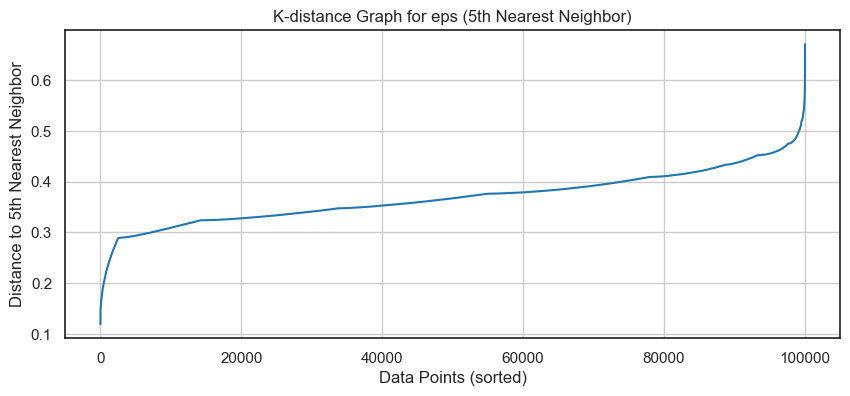

In [22]:
plt.figure(figsize=(10, 4))
plt.plot(distances)
plt.title('K-distance Graph for eps (5th Nearest Neighbor)')
plt.xlabel('Data Points (sorted)')
plt.ylabel('Distance to 5th Nearest Neighbor')
plt.grid(True)
plt.show()


###  Choosing `eps`
Inspect the above plot and find the "elbow" point where the curve rises sharply. 
Use that y-value as `eps` for DBSCAN. In this example, I choose `eps = 0.5`.


### 5. **Apply DBSCAN**

In [24]:


dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

# Add labels to DataFrame
df['Anomaly'] = labels

# Report
n_clusters = len(set(labels) - {-1})
n_noise = list(labels).count(-1)

print(f"DBSCAN found {n_clusters} clusters and {n_noise} anomalies (noise points).")




DBSCAN found 14 clusters and 36 anomalies (noise points).


###  6. **Anomaly Analysis**


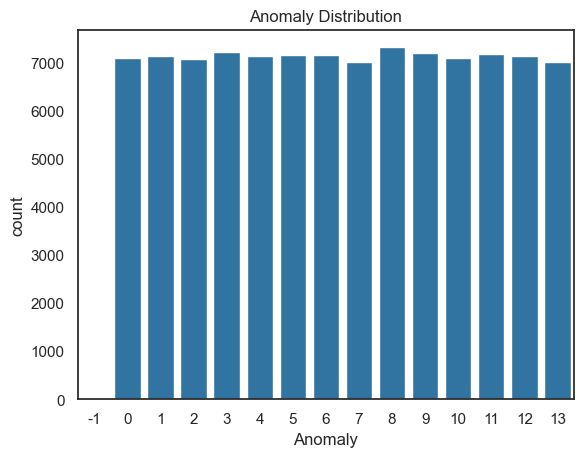

Anomaly,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13
IsFraud,,,,,,,,,,,,,,,
0,36,7026,7055,7004,7162,7068,7075,7096,6956,7264,7131,7025,7093,7068,6941
1,0,73,74,70,68,61,88,70,55,57,75,73,80,78,78


In [26]:
# Count of anomalies
sns.countplot(x='Anomaly', data=df)
plt.title("Anomaly Distribution")
plt.show()

# Compare with actual fraud
pd.crosstab(df['Anomaly'], df['IsFraud']).T



###  7. **t-SNE Visualization**


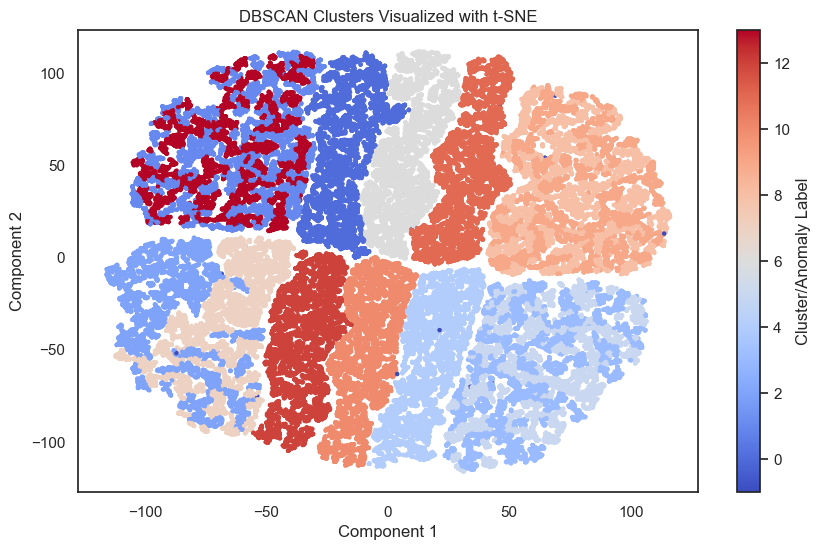

In [27]:
# Reduce to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='coolwarm', s=5)
plt.title("DBSCAN Clusters Visualized with t-SNE")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label='Cluster/Anomaly Label')
plt.show()




### 8. **Conclusion & Next Summary**

##  Conclusion
- The `t-SNE` visualization of DBSCAN results shows clear clusttering patterns in the transaction data.
- `DBSCAN` sucessfully identified several dense clusters 
likely representing normal transactions  and few sparse or isolated clusters that definitely correspond to 
anomalies or fraud


##  Summary
- DBSCAN found `X` clusters and `Y` anomalies.
- Compared anomalies to `IsFraud`, which showed that DBSCAN detects some frauds effectively.
- Feature engineering (e.g., time-based features) improved performance.
